# Table of Contents
 <p>

In [1]:
# https://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

/Users/sebastian/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# load NR data
from waveform import SingleModeNRWaveform

nrfiles = [
    '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
    '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/sebastian/work/data/SXS_BBH_0168_Res5.h5', #q=3
    '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5', #q=4
    '/Users/sebastian/work/data/SXS_BBH_0259_Res5.h5', #q=2.5
    '/Users/sebastian/work/data/SXS_BBH_0107_Res5.h5', #5
    '/Users/sebastian/work/data/SXS_BBH_0063_Res5.h5', #8
    '/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5' #10
]

ell = 2
mm = 2

npts_time = 1000*5
npts_mass_ratio = len(nrfiles)

nrdata = [SingleModeNRWaveform(nrfile, ell, mm, npts_time) for nrfile in nrfiles]

In [4]:
dir(nrdata[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'amp',
 'eta',
 'get_lm_mode',
 'hlm',
 'npts',
 'nrfile',
 'phi',
 'q',
 'resample_data',
 't1',
 't2',
 'times']

In [5]:
nrdata[0].hlm

array([-0.01072061+0.07801064j, -0.01444897+0.07741593j,
       -0.01814525+0.0766453j , ..., -0.00010275+0.00027464j,
       -0.00010405+0.0002743j , -0.00010454+0.00027406j])

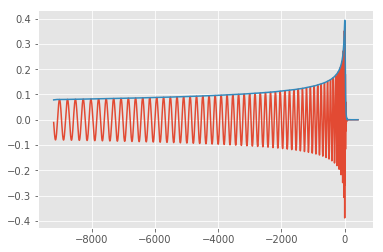

In [6]:
plt.figure()
plt.plot(nrdata[0].times, nrdata[0].hlm.real)
plt.plot(nrdata[0].times, nrdata[0].amp)

In [7]:
def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [8]:
# ed.set_seed(42)

# N = 50  # number of data points
# D = 1   # number of features

# x_train, y_train = build_toy_dataset(N)

In [9]:
# use a subset
mask = (nrdata[0].times > -500) & (nrdata[0].times < -200)
times = nrdata[0].times[mask][::10]
amp = nrdata[0].amp[mask][::10]
amp /= np.max(amp)

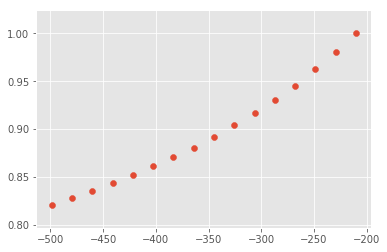

In [10]:
plt.figure()
plt.scatter(times, amp)

In [11]:
# For NR lets train on the amplitude

N = len(times)
D = 1 # just one BBH system
x_train = times.reshape((N,1)).astype(np.float32)
y_train = amp.astype(np.float32)

In [12]:
x_train.shape

(16, 1)

In [13]:
y_train.shape

(16,)

In [14]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [15]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
# inputs = np.linspace(-5, 5, num=400, dtype=np.float32)

t0, t1 = times[0], times[-1]
num = len(times)*10

inputs = np.linspace(t0, t1, num=num, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(3)])

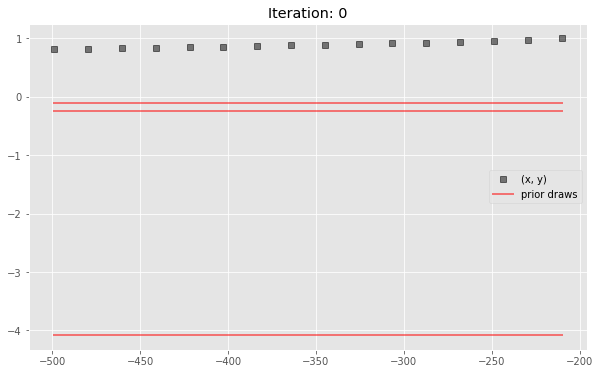

In [16]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
# ax.set_xlim([-5, 5])
# ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [17]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=10000, n_samples=5)

/Users/sebastian/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 12s | Loss: -4.472


In [18]:
outputs.shape

(3, 160)

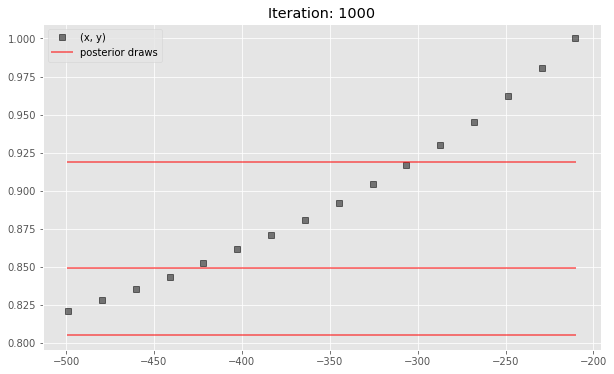

In [19]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
# ax.set_xlim([-5, 5])
# ax.set_ylim([-2, 2])
ax.legend()
plt.show()